In [1]:
import pandas as pd
import json
import os
import pickle
import numpy as np
import random
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
import multiprocessing

INFO - 22:21:55: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 22:21:55: built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)
INFO - 22:21:55: Dictionary lifecycle event {'msg': "built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)", 'datetime': '2022-04-14T22:21:55.682681', 'gensim': '4.1.2', 'python': '3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [41]:
# Start the spacy lemmatization
nlp = spacy.load('en_core_web_md', disable = ['parser','ner'])
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)
    else:
        return ' '

In [42]:
def cleaningText(arrTxt):
    brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower().replace('\d+', '') for row in arrTxt)
    txt = []
    count = 0
    start = time()
    with nlp.select_pipes(enable="lemmatizer"):
        for doc in nlp.pipe(brief_cleaning, batch_size=1000, n_process=-1):
            if count % 50000 == 0:
                print('processed:', count, 'Time {} mins'.format(round((time() - start) / 60, 2)))
            count += 1
            txt.append(cleaning(doc))
    return np.array(txt)

In [43]:
def shuffleData(dfIn, colID):
    dfCount = dfIn.groupby([colID]).count().reset_index()
    dfCount = dfCount.sort_values(by=dfCount.columns[1])
    lstID = dfCount[colID].unique()
    lstDF = []
    valBase = 0
    for idx, valID in enumerate(lstID):
        if idx == 0:
            dfTmp = dfIn[dfIn[colID]==valID]
            valBase = len(dfTmp)
        else:
            dfTmp = dfIn[dfIn[colID]== valID]
            valSize = len(dfTmp)
            if abs((valSize - valBase)/valBase) > 0.1:
                valNewSize = int((random.randrange(90,110,1))/100 * valBase)
                dfTmp = dfTmp.sample(valNewSize).copy()
        lstDF.append(dfTmp)
    dfShuffle = pd.concat(lstDF, ignore_index=True).sample(frac=1).reset_index(drop=True)
    return dfShuffle

In [52]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, w2vReal, w2vFake):
        self.w2vReal = w2vReal
        self.w2vFake = w2vFake
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dimFake = w2vFake.wv.vector_size
        self.dimReal = w2vReal.wv.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        arrWordCleaning = cleaningText(X)
        arrReal = np.array([np.mean([self.w2vReal.wv[w] for w in words if w in self.w2vReal.wv]
                            or [np.zeros(self.dimReal)], axis=0) for words in arrWordCleaning])
        arrFake = np.array([np.mean([self.w2vFake.wv[w] for w in words if w in self.w2vFake.wv]
                            or [np.zeros(self.dimFake)], axis=0) for words in arrWordCleaning])
        arrMerge = np.concatenate((arrReal, arrFake), axis=1)
        return arrMerge

START

In [53]:
w2vFake = Word2Vec.load('word2vec-Yelp-fake-80Kcomment-v2-100vec.model')
w2vReal = Word2Vec.load('word2vec-Yelp-real-500Kcomment-v2-100vec.model')

INFO - 22:52:34: loading Word2Vec object from word2vec-Yelp-fake-80Kcomment-v2-100vec.model
INFO - 22:52:35: loading wv recursively from word2vec-Yelp-fake-80Kcomment-v2-100vec.model.wv.* with mmap=None
INFO - 22:52:35: setting ignored attribute cum_table to None
INFO - 22:52:36: Word2Vec lifecycle event {'fname': 'word2vec-Yelp-fake-80Kcomment-v2-100vec.model', 'datetime': '2022-04-14T22:52:36.110975', 'gensim': '4.1.2', 'python': '3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}
INFO - 22:52:36: loading Word2Vec object from word2vec-Yelp-real-500Kcomment-v2-100vec.model
INFO - 22:52:36: loading wv recursively from word2vec-Yelp-real-500Kcomment-v2-100vec.model.wv.* with mmap=None
INFO - 22:52:36: loading vectors from word2vec-Yelp-real-500Kcomment-v2-100vec.model.wv.vectors.npy with mmap=None
INFO - 22:52:37: loading syn1neg from word2vec-Yelp-real-500Kcomment-v2-100vec.model.syn1neg.npy with 

In [10]:
dfReview = pd.read_pickle('yelp-600K-review.pkl', compression='gzip')

In [54]:
dfReview.head(5)

,userId,prod_id,date,text,star,realFake
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",1.0,-1
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,1.0,-1
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,3.0,-1
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,5.0,-1
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,5.0,-1


In [ ]:
# # testVectorize = MeanEmbeddingVectorizer(w2vReal=w2vReal, w2vFake=w2vFake)

# arrReturn = testVectorize.transform(dfTest['text'])

# dfReview.head()

# dfFake = dfReview[dfReview['realFake']==-1].copy()

# dfFake['realFake'] = 0

# dfReal = dfReview[dfReview['realFake']==1].sample(85000).copy()

# df160K = pd.concat([dfFake, dfReal], ignore_index=True)

# df160KShuffle = df160K.sample(frac=1).reset_index(drop=True)

In [55]:
df160KShuffle = shuffleData(dfReview, 'realFake')

In [56]:
vectorizedTrain = MeanEmbeddingVectorizer(w2vReal=w2vReal, w2vFake=w2vFake)

In [57]:
arrText = vectorizedTrain.transform(df160KShuffle['text'])

processed: 0 Time 1.48 mins
processed: 50000 Time 2.8 mins
processed: 100000 Time 3.89 mins
processed: 150000 Time 4.99 mins


In [59]:
X_train, X_test, y_train, y_test = train_test_split(arrText, df160KShuffle['realFake'], test_size=0.2, random_state=42)

In [ ]:
y_train.head()

In [69]:
clasRelu = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-07,
       hidden_layer_sizes=(100, 100,), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=50, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.2,
       verbose=True, warm_start=True)

In [70]:
clasRelu.fit(X_train, y_train)

Iteration 1, loss = 0.68596728
Iteration 2, loss = 0.68124929
Iteration 3, loss = 0.67976762
Iteration 4, loss = 0.67875136
Iteration 5, loss = 0.67837917
Iteration 6, loss = 0.67811433
Iteration 7, loss = 0.67705537
Iteration 8, loss = 0.67601502
Iteration 9, loss = 0.67555389
Iteration 10, loss = 0.67485957
Iteration 11, loss = 0.67446154
Iteration 12, loss = 0.67416298
Iteration 13, loss = 0.67404707
Iteration 14, loss = 0.67374656
Iteration 15, loss = 0.67391443
Iteration 16, loss = 0.67385010
Iteration 17, loss = 0.67354426
Iteration 18, loss = 0.67395895
Iteration 19, loss = 0.67364572
Iteration 20, loss = 0.67405239
Iteration 21, loss = 0.67371717
Iteration 22, loss = 0.67360928


c:\users\tt\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(epsilon=1e-07, hidden_layer_sizes=(100, 100),
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=50,
              random_state=1, validation_fraction=0.2, verbose=True,
              warm_start=True)

In [64]:
y_pred = clasRelu.predict(X_train)

In [66]:
clf = LogisticRegression(penalty='l2', max_iter=500)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [67]:
y_pred = clf.predict(X_train)

In [ ]:
arrConfusion = confusion_matrix(y_test, y_pred, labels=[0, 1])

In [ ]:
arrConfusion

<IPython.core.display.Javascript object>


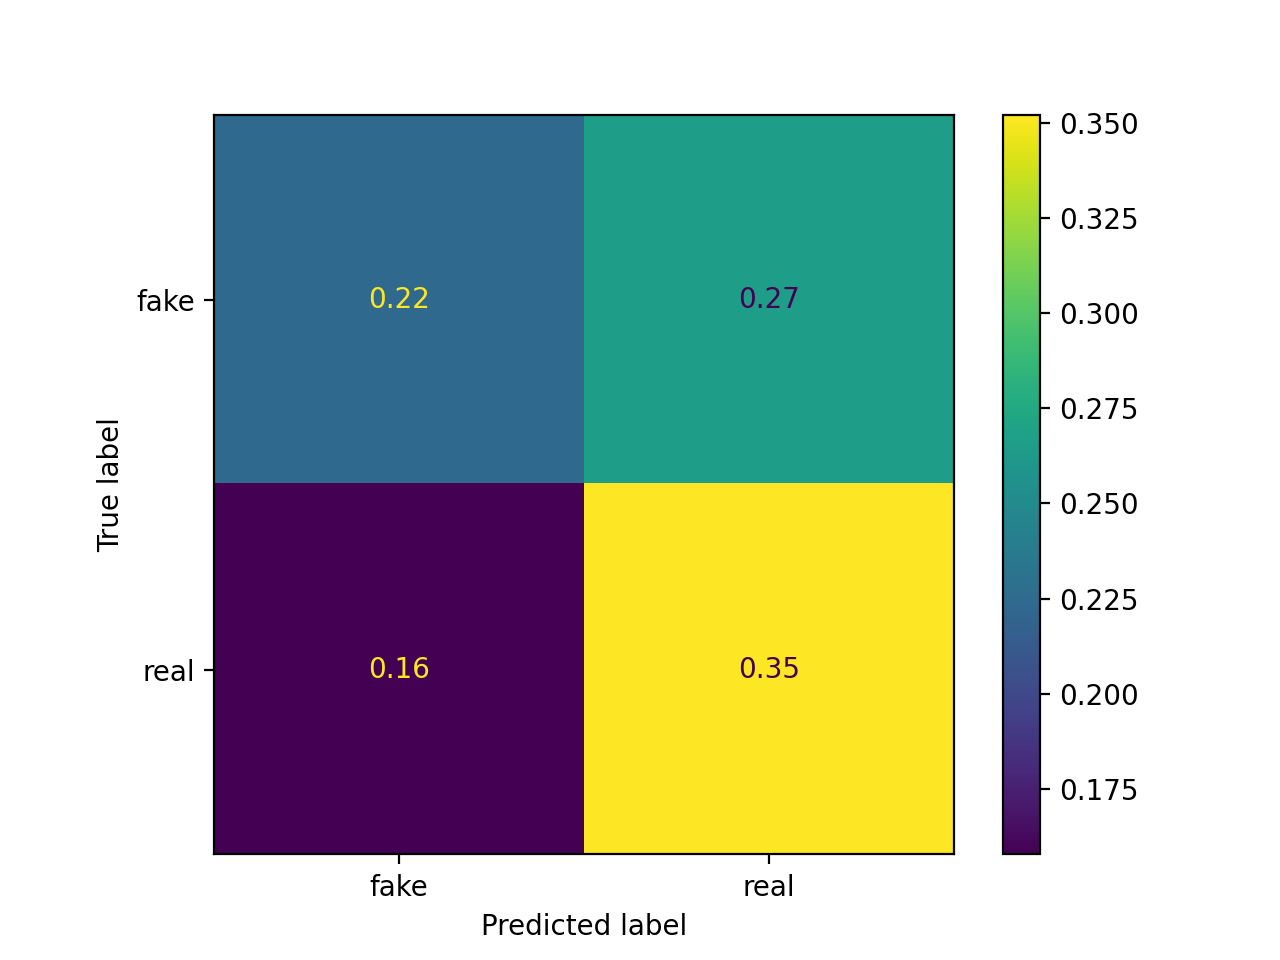

In [68]:
cm = confusion_matrix(y_train, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['fake','real'])
cmd.plot()

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
exTree = ExtraTreesClassifier(n_estimators=30)

In [ ]:
np.arange(50, 400, 50)

In [71]:
train_scores, valid_scores = validation_curve(ExtraTreesClassifier(), X_train, y_train, 
                                              param_name="n_estimators", param_range=np.arange(10, 50, 10),
                                              cv=5, scoring='accuracy')

In [ ]:
exTree.fit(arrWVTrain, y_train)

In [ ]:
y_pred = exTree.predict(arrWVTrain)

In [ ]:
arrConfusion = confusion_matrix(y_train, y_pred, labels=[0, 1])

In [ ]:
arrConfusion

In [72]:
train_scores, valid_scores

(array([[0.99642925, 0.99662925, 0.9964769 , 0.99655307, 0.99654355],
        [0.99642925, 0.99662925, 0.9964769 , 0.99655307, 0.99654355],
        [0.99642925, 0.99662925, 0.9964769 , 0.99655307, 0.99654355],
        [0.99642925, 0.99662925, 0.9964769 , 0.99655307, 0.99654355]]),
 array([[0.55792962, 0.55421824, 0.55509427, 0.55520853, 0.55448486],
        [0.56661335, 0.57341459, 0.57131975, 0.57166254, 0.57288136],
        [0.57990555, 0.57741383, 0.57550943, 0.57752809, 0.57615692],
        [0.58474254, 0.58373643, 0.57775662, 0.58133689, 0.57988954]]))

In [ ]:
arrTrainMean = np.mean(train_scores, axis=1)
arrTrainStd = np.std(train_scores, axis=1)
arrValidMean = np.mean(valid_scores, axis=1)
arrVaidStd = np.std(valid_scores, axis=1)

In [ ]:
plt.close()
arrRange = np.arange(10, 50, 10)
plt.plot(arrRange, arrTrainMean, label='train-score')
plt.plot(arrRange, arrValidMean, label='cross-valid')

Using Bag of words

In [7]:
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
instTFidf = TfidfVectorizer(max_features=2200, 
                                stop_words=STOP_WORDS,
                                ngram_range=(1,2)
                               )

In [75]:
# df160KShuffle = shuffleData(dfReview, 'realFake')

arrText = df160KShuffle['text'].to_numpy()

In [76]:
arrText = cleaningText(arrText)

processed: 0 Time 1.06 mins
processed: 50000 Time 2.1 mins
processed: 100000 Time 3.14 mins
processed: 150000 Time 4.19 mins


In [77]:
arrTFidf = instTFidf.fit_transform(arrText)

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(arrTFidf, df160KShuffle['realFake'], test_size=0.2, random_state=42)

In [79]:
instMNB = MultinomialNB()
instMNB.fit(X_train, y_train)

MultinomialNB()

In [80]:
y_pred = instMNB.predict(X_train)

In [49]:
arrConfusion = confusion_matrix(y_train, y_pred, labels=[-1, 1])
arrConfusion

array([[44484, 19868],
       [23665, 39398]], dtype=int64)

<IPython.core.display.Javascript object>


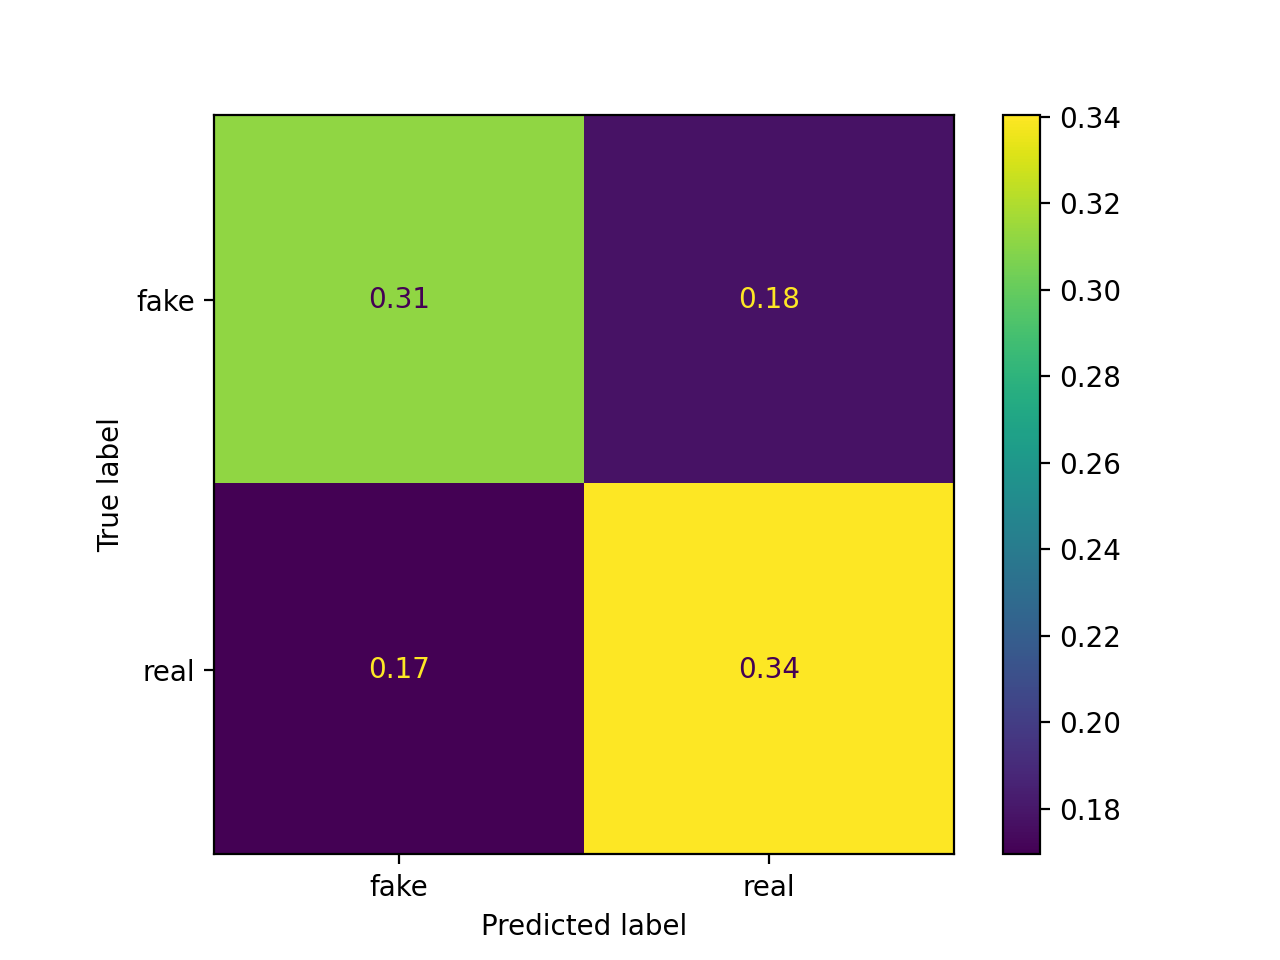

In [81]:
cm = confusion_matrix(y_train, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['fake','real'])
cmd.plot()

In [34]:
clf = LogisticRegression(penalty='l2', max_iter=500)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [37]:
y_pred = clf.predict(X_train)

In [82]:
train_scores, valid_scores = validation_curve(ExtraTreesClassifier(), X_train, y_train, 
                                              param_name="n_estimators", param_range=np.arange(10, 50, 10),
                                              cv=5, scoring='accuracy')

In [83]:
train_scores, valid_scores

(array([[0.99622929, 0.99641024, 0.99627694, 0.99641024, 0.99633407],
        [0.99622929, 0.99641024, 0.99627694, 0.99641024, 0.99633407],
        [0.99622929, 0.99641024, 0.99627694, 0.99641024, 0.99633407],
        [0.99622929, 0.99641024, 0.99627694, 0.99641024, 0.99633407]]),
 array([[0.6176493 , 0.61443535, 0.61256903, 0.61592078, 0.61443535],
        [0.63791133, 0.63222243, 0.63664064, 0.63656446, 0.6323367 ],
        [0.64754723, 0.64860027, 0.65031423, 0.64867644, 0.64380118],
        [0.65196527, 0.64601028, 0.65107599, 0.6481813 , 0.64700057]]))